In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn

import sklearn

In [ ]:
data = pd.read_csv("attribution_data.csv")
data.head()

,customer_id,time,interaction,conversion,conversion_value,channel
0,A000100,2018-07-22T20:40:41Z,impression,0,0.0,Online Display
1,A000100,2018-07-08T21:53:37Z,impression,0,0.0,Online Video
2,A000100,2018-07-28T08:15:09Z,impression,0,0.0,Facebook
3,A000100,2018-07-20T17:34:47Z,impression,0,0.0,Paid Search
4,A000100,2018-07-12T07:43:32Z,impression,0,0.0,Facebook


In [ ]:
data.groupby('channel')['customer_id'].count().reset_index()

,channel,customer_id
0,Facebook,18676
1,Instagram,8037
2,Online Display,7688
3,Online Video,11694
4,Paid Search,16388


In [ ]:
data['channel'].value_counts(normalize=True) * 100

,proportion
channel,
Facebook,29.889730
Paid Search,26.227934
Online Video,18.715491
Instagram,12.862699
Online Display,12.304147


1. Reformat the data for the inputs into `networkx` plots

In [ ]:
## Make the plots for customers with impression and conversion respectively
df = data[data['interaction']=='impression'].sort_values(by = ['customer_id', 'time'])
df['TO'] = df.groupby('customer_id')['channel'].shift(-1)
df['TO'] = np.where(df['TO'].isna(), df['interaction'], df['TO'])
df = df[['customer_id', 'time', 'channel', 'TO']].rename(columns={'channel': 'FROM'})
df = df.merge(df.groupby(['FROM', 'TO'])['customer_id'].count().reset_index().rename(columns={'customer_id':'PATH_FREQ'}),
              on = ['FROM', 'TO'])
df.head()

,customer_id,time,FROM,TO,PATH_FREQ
0,A000100,2018-07-08T21:53:37Z,Online Video,Facebook,3003
1,A000100,2018-07-12T07:43:32Z,Facebook,Paid Search,3819
2,A000100,2018-07-19T16:37:23Z,Paid Search,Paid Search,3864
3,A000100,2018-07-20T17:34:47Z,Paid Search,Online Display,1789
4,A000100,2018-07-22T20:40:41Z,Online Display,Facebook,2023


2. Config the parameters in the `networkx` function and make the network plots by inputting the data prepared in *Step 1*

In [ ]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib.pyplot import figure

In [ ]:
print(f'NetworkX version: {nx.__version__}')

NetworkX version: 3.4.2


In [ ]:
G = nx.from_pandas_edgelist(df[df['TO']!='conversion'], source='FROM', target='TO', edge_attr=True, create_using=nx.DiGraph())
nodes, degree = map(list, zip(*list(G.degree())))
nodes, degree

(['Online Video',
  'Facebook',
  'Paid Search',
  'Online Display',
  'impression',
  'Instagram'],
 [11, 11, 11, 11, 5, 11])

In [ ]:
# Recalculate the degree (aka node size)
node_size = pd.concat([data.groupby('channel')['customer_id'].count().reset_index().rename(columns={'channel': 'NODE', 'customer_id': 'SIZE'}),
                      df[df['TO'].isin(['impression'])].groupby('TO')['customer_id'].count().reset_index().rename(columns={'TO': 'NODE', 'customer_id': 'SIZE'})])
node_size['NODE_c'] = pd.Categorical(node_size['NODE'], categories=['Online Video','Facebook','Paid Search',
                                                                    'Online Display','impression','Instagram'], ordered=True)
node_size = node_size.sort_values(by='NODE_c')
node_size_list = list(zip(node_size['NODE'], node_size['SIZE']))
node_size_list

[('Online Video', 11694),
 ('Facebook', 18676),
 ('Paid Search', 16388),
 ('Online Display', 7688),
 ('impression', 7894),
 ('Instagram', 8037)]

In [ ]:
# # Recalculate the degree (aka node size)
# node_size = pd.concat([data.groupby('channel')['customer_id'].count().reset_index().rename(columns={'channel': 'NODE', 'customer_id': 'SIZE'}),
#                       df[df['TO'].isin(['impression', 'conversion'])].groupby('TO')['customer_id'].count().reset_index().rename(columns={'TO': 'NODE', 'customer_id': 'SIZE'})])
# node_size['NODE_c'] = pd.Categorical(node_size['NODE'], categories=['Online Video','Facebook','Paid Search',
#                                                                     'Online Display','impression','Instagram',
#                                                                     'conversion'], ordered=True)
# node_size = node_size.sort_values(by='NODE_c')
# node_size_list = list(zip(node_size['NODE'], node_size['SIZE']))
# node_size_list

<ipython-input-71-248eccc4c03c>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(G, with_labels=True, cmap=plt.cm.get_cmap('Set3'), node_color=colors, font_size=12,


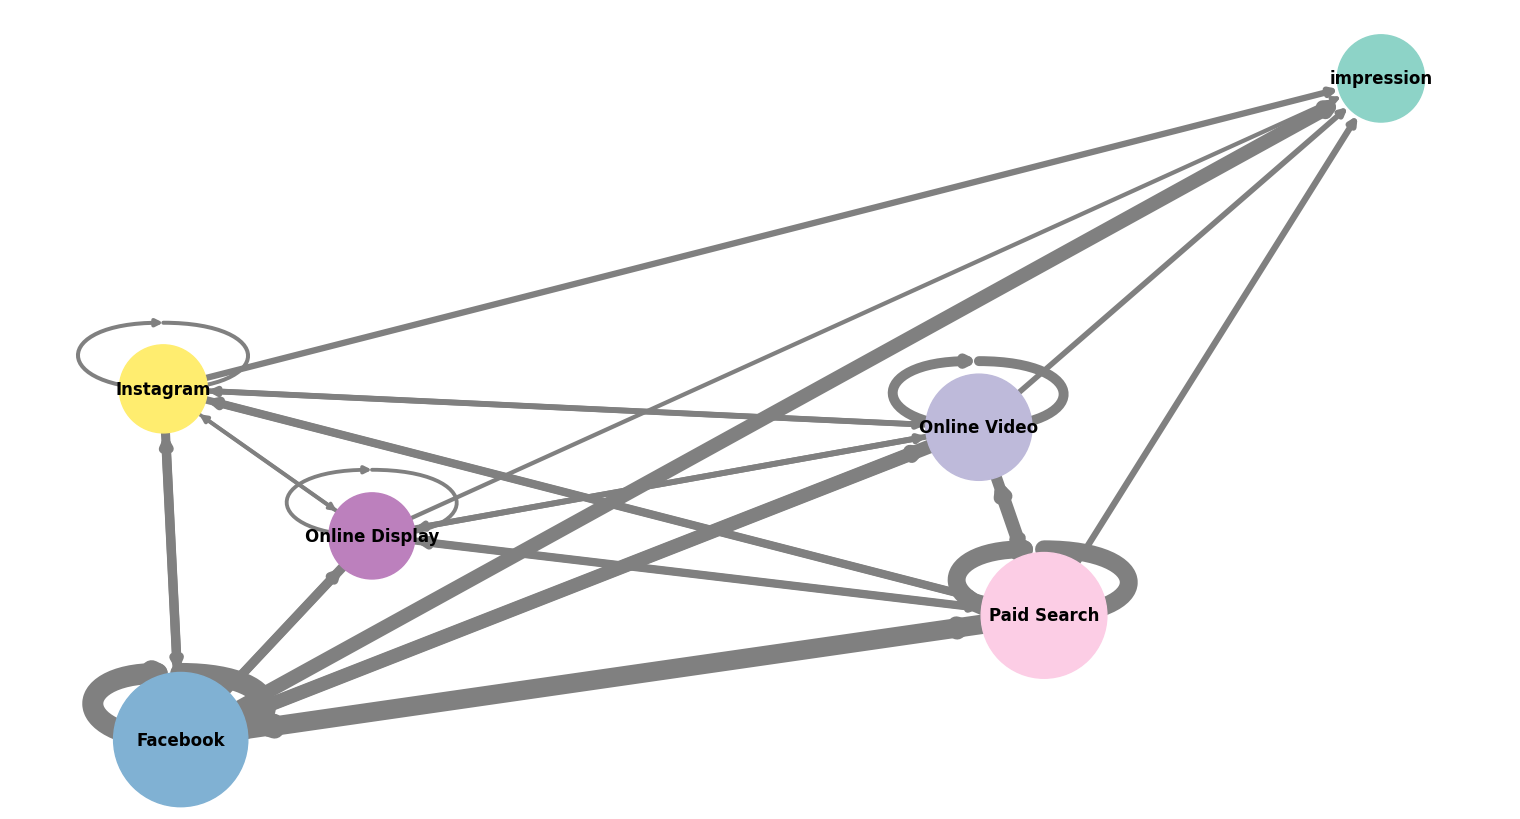

In [ ]:
G = nx.from_pandas_edgelist(df, source='FROM', target='TO', edge_attr=True, create_using=nx.DiGraph())
nodes, degree = map(list, zip(*node_size_list))
edges, freqs = zip(*nx.get_edge_attributes(G, 'PATH_FREQ').items())
colors = []
i = 1
for node in G:
  if node == 'conversion' or node == 'impression':
    colors.append(0)
  else:
    colors.append(i)
    i = i+1

figure(figsize=(15, 8))
nx.draw(G, with_labels=True, cmap=plt.cm.get_cmap('Set3'), node_color=colors, font_size=12,
        font_weight='bold', edge_color='gray', width = [int(f)/300 for f in freqs],
        node_size=[int(d)/2 for d in degree])
plt.show()